 # #**Práctica: K-Means con Datos Sintéticos**

## **1. Configuración inicial e importaciones**
En esta sección se importan las librerías necesarias y se establece la semilla para reproducibilidad.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import random

# Para reproducibilidad de resultados
np.random.seed(42)

## **2. Generación de Datos Sintéticos**
La siguiente función genera datos sintéticos en distintas dimensiones, distribuidos en 3 clusters (centroides "reales").
- `n_muestras`: Número total de muestras.
- `dimensiones`: Dimensionalidad de los datos (2D, 3D, 10D, 100D, etc.).
- Retorna una matriz `X` de tamaño (n_muestras, dimensiones).


In [ ]:
def generar_datos_sinteticos(n_muestras=1000, dimensiones=2):
    """
    Genera datos sintéticos con una distribución normal alrededor de 3 centroides.
    """
    # Para 2D usamos centroides fijos
    if dimensiones == 2:
        centroides_reales = np.array([[2, 2], [6, 6], [10, 2]])
    else:
        # Para d > 2, generamos 3 centroides con valores aleatorios "moderados"
        centroides_reales = []
        for i in range(3):
            centroides_reales.append(np.random.randint(1, 10, size=dimensiones))
        centroides_reales = np.array(centroides_reales)

    X = []
    grupo_tamano = n_muestras // 3  # Dividimos las muestras en 3 grupos

    for centro in centroides_reales:
        # Matriz de covarianza (diagonal) aleatoria para cada grupo
        cov = np.eye(dimensiones) * np.random.uniform(0.5, 1.5)
        grupo = np.random.multivariate_normal(centro, cov, size=grupo_tamano)
        X.append(grupo)

    X = np.vstack(X)

    # Si n_muestras no es múltiplo de 3, se agregan muestras extras al último grupo
    if X.shape[0] < n_muestras:
        faltantes = n_muestras - X.shape[0]
        extra = np.random.multivariate_normal(centroides_reales[-1],
                                              np.eye(dimensiones),
                                              size=faltantes)
        X = np.vstack([X, extra])

    return X

## **3. Funciones de Distancia**
Definimos las funciones para calcular:
- Distancia Euclidiana  
- Distancia Manhattan  
- Distancia Mahalanobis  
Para la Mahalanobis se requiere la inversa de la matriz de covarianza.


In [ ]:
def distancia_euclidiana(p, q):
    return np.sqrt(np.sum((p - q)**2))

def distancia_manhattan(p, q):
    return np.sum(np.abs(p - q))

def distancia_mahalanobis(p, q, cov_inv):
    diff = p - q
    return np.sqrt(diff.T @ cov_inv @ diff)

## **4. Implementación de K-Means**
Esta función implementa el algoritmo K-Means con la opción de elegir la métrica de distancia.
- Se inicializan centroides aleatorios.
- Se asigna cada muestra al centroide más cercano.
- Se actualizan los centroides y se verifica la convergencia.
- Si un cluster queda vacío, se reasigna un centroide aleatorio.


In [ ]:
def kmeans(X, k=3, max_iter=100, distancia='euclidiana'):
    """
    Implementación básica de K-Means con opciones de distancia:
    'euclidiana', 'manhattan', 'mahalanobis'.

    Retorna:
    - centroides finales
    - etiquetas (asignación de cada muestra a un cluster)
    - número de iteraciones ejecutadas
    """
    n_muestras, n_dimensiones = X.shape

    # Inicialización aleatoria de centroides
    indices_aleatorios = np.random.choice(n_muestras, k, replace=False)
    centroides = X[indices_aleatorios, :]

    # Para la distancia Mahalanobis, calcular la inversa de la covarianza global
    if distancia == 'mahalanobis':
        cov = np.cov(X, rowvar=False)
        cov_inv = inv(cov)
    else:
        cov_inv = None

    for iteracion in range(max_iter):
        # Asignación de cada muestra al cluster más cercano
        etiquetas = []
        for x in X:
            distancias = []
            for c in centroides:
                if distancia == 'euclidiana':
                    distancias.append(distancia_euclidiana(x, c))
                elif distancia == 'manhattan':
                    distancias.append(distancia_manhattan(x, c))
                elif distancia == 'mahalanobis':
                    distancias.append(distancia_mahalanobis(x, c, cov_inv))
            etiquetas.append(np.argmin(distancias))
        etiquetas = np.array(etiquetas)

        # Actualización de centroides
        nuevos_centroides = []
        for cluster_idx in range(k):
            puntos_cluster = X[etiquetas == cluster_idx]
            if len(puntos_cluster) > 0:
                nuevos_centroides.append(np.mean(puntos_cluster, axis=0))
            else:
                # Si un cluster queda vacío, se reasigna un centroide aleatorio
                nuevos_centroides.append(X[np.random.choice(n_muestras)])
        nuevos_centroides = np.array(nuevos_centroides)

        # Verificar convergencia (si no hay cambios significativos en los centroides)
        if np.allclose(centroides, nuevos_centroides, atol=1e-6):
            return nuevos_centroides, etiquetas, iteracion + 1

        centroides = nuevos_centroides

    return centroides, etiquetas, max_iter

## **5. Función para Ejecutar Experimentos**
Esta función facilita la ejecución de múltiples corridas de K-Means para distintos valores de `max_iter`.  
- Genera los datos sintéticos.
- Corre K-Means y promedia el número de iteraciones hasta convergencia.
- Retorna un diccionario con los resultados.


In [ ]:
def ejecutar_experimento(n_muestras=1000, dimensiones=2, k=3,
                         distancia='euclidiana', max_iters=[10, 100, 1000, 10000],
                         num_corridas=5):
    """
    Ejecuta varias corridas de K-Means para un conjunto de valores de 'max_iter'.
    Retorna un diccionario con información relevante de cada experimento.
    """
    resultados = {}

    # Generamos los datos sintéticos una sola vez para consistencia
    X = generar_datos_sinteticos(n_muestras, dimensiones)

    for m_iter in max_iters:
        iteraciones_promedio = 0
        for _ in range(num_corridas):
            centroides, etiquetas, it = kmeans(X, k=k, max_iter=m_iter, distancia=distancia)
            iteraciones_promedio += it

        iteraciones_promedio /= num_corridas

        resultados[m_iter] = {
            'iteraciones_promedio': iteraciones_promedio,
            'distancia': distancia,
            'dimensiones': dimensiones,
            'k': k
        }
    return resultados

# # **6. Ejecución de los 6 Experimentos**



### **Experimento 1**: 2D, k=3, Euclidiana


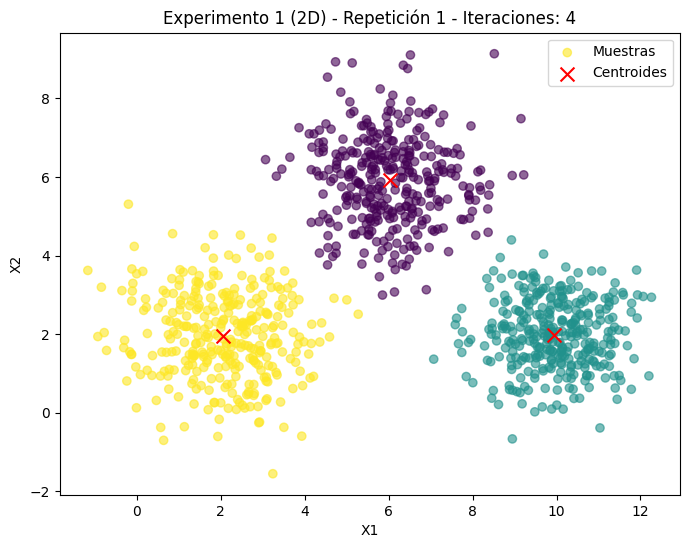

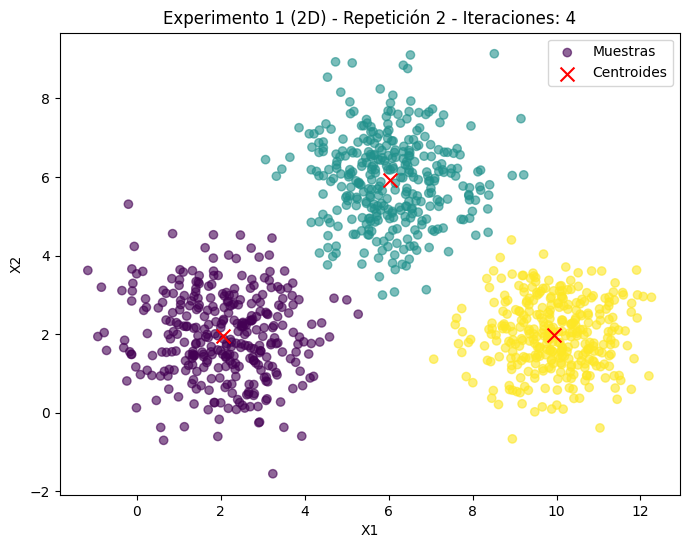

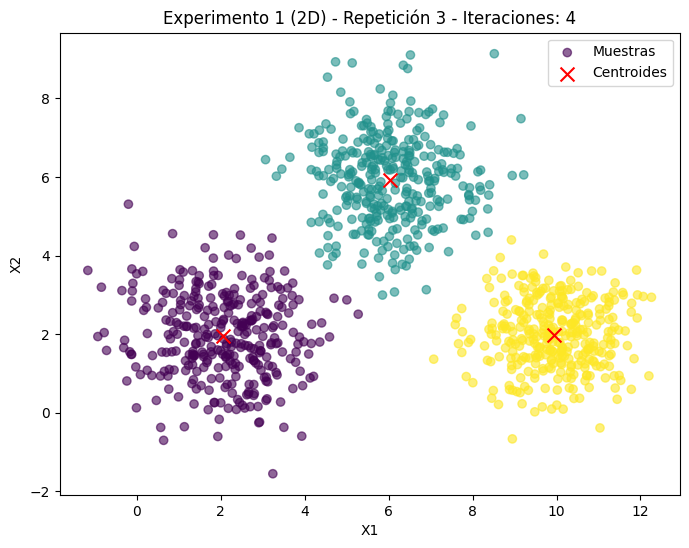

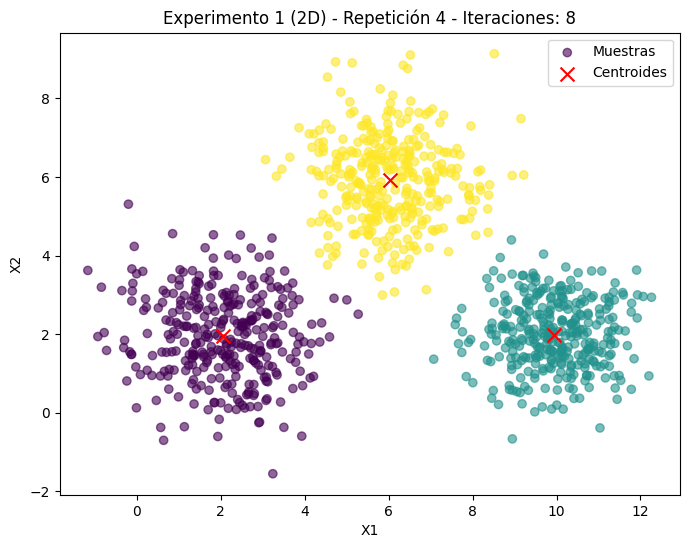

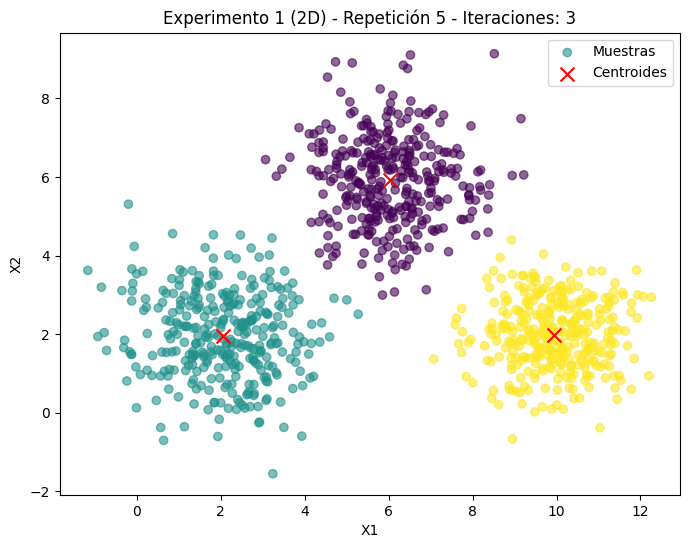

In [ ]:
# Generamos los datos 2D una sola vez para mantener la consistencia entre repeticiones
X_2D = generar_datos_sinteticos(n_muestras=1000, dimensiones=2)

# Número de repeticiones (corridas)
num_corridas = 5

for rep in range(num_corridas):
    # Ejecutamos K-Means para cada repetición
    centroides, etiquetas, it = kmeans(X_2D, k=3, max_iter=1000, distancia='euclidiana')

    # Creamos la gráfica para la repetición actual
    plt.figure(figsize=(8,6))
    plt.scatter(X_2D[:, 0], X_2D[:, 1], c=etiquetas, cmap='viridis', alpha=0.6, label='Muestras', zorder=1)
    plt.scatter(centroides[:, 0], centroides[:, 1], c='red', marker='x', s=100, label='Centroides', zorder=2)
    plt.title(f"Experimento 1 (2D) - Repetición {rep+1} - Iteraciones: {it}")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

### **Experimento 2**: 3D, k=3, Euclidiana  

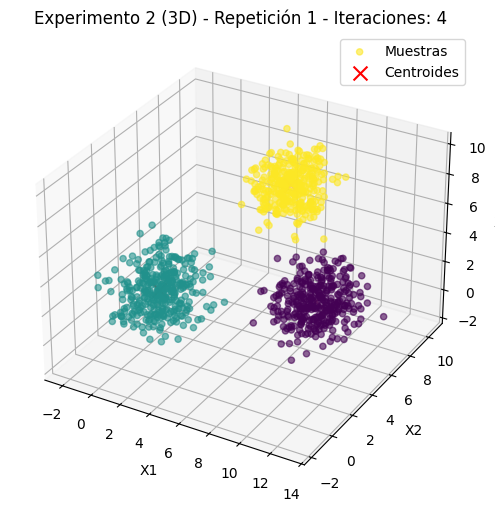

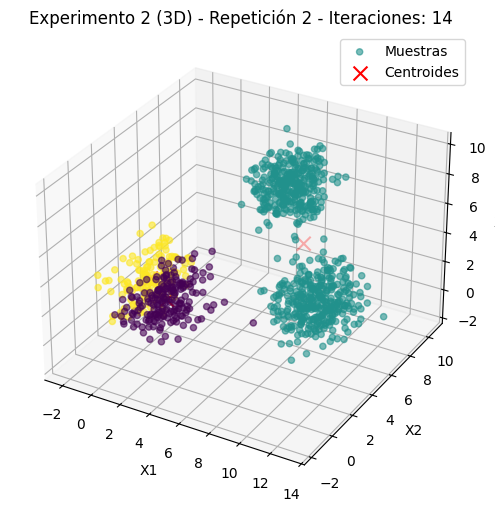

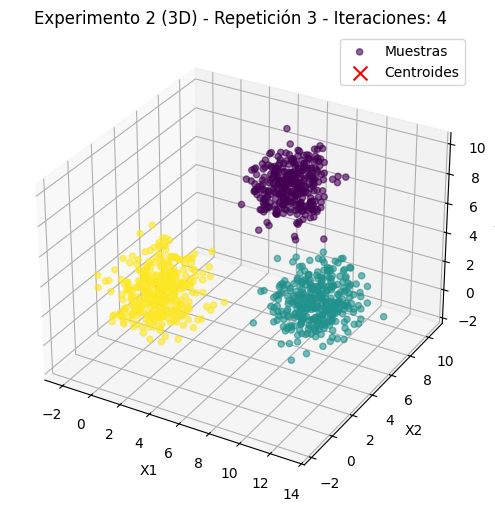

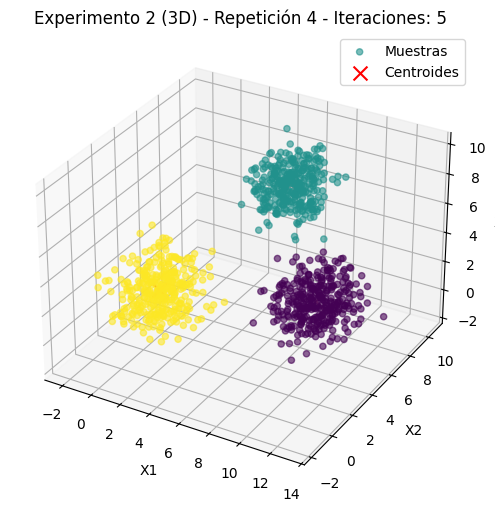

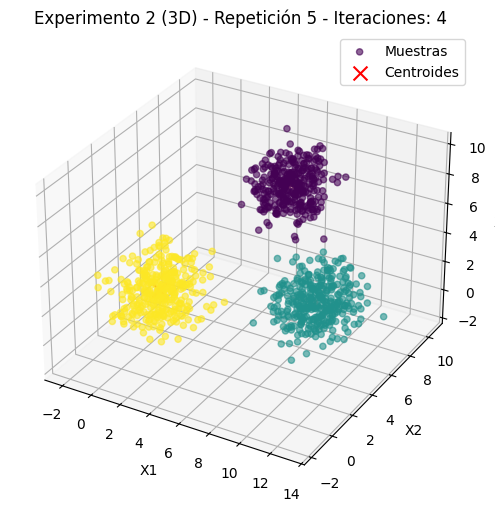

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


# Generamos los datos 3D una sola vez para mantener la consistencia entre repeticiones
X_3D = generar_datos_sinteticos(n_muestras=1000, dimensiones=3)

# Número de repeticiones (corridas)
num_corridas = 5

for rep in range(num_corridas):
    # Ejecutamos K-Means para cada repetición
    centroides, etiquetas, it = kmeans(X_3D, k=3, max_iter=1000, distancia='euclidiana')

    # Creamos una nueva figura 3D para la repetición actual
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # Graficamos las muestras en 3D
    scatter = ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2],
                         c=etiquetas, cmap='viridis', alpha=0.6, label='Muestras')

    # Graficamos los centroides
    ax.scatter(centroides[:, 0], centroides[:, 1], centroides[:, 2],
               c='red', marker='x', s=100, label='Centroides')

    ax.set_title(f"Experimento 2 (3D) - Repetición {rep+1} - Iteraciones: {it}")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("X3")
    ax.legend()
    plt.show()


### **Experimento 3**: 10D, k=3, Euclidiana

=== Resultados Experimento 3 (10D, k=3, Euclidiana) ===
max_iter=10, iteraciones_promedio=2.80
max_iter=100, iteraciones_promedio=6.80
max_iter=1000, iteraciones_promedio=4.40
max_iter=10000, iteraciones_promedio=11.60


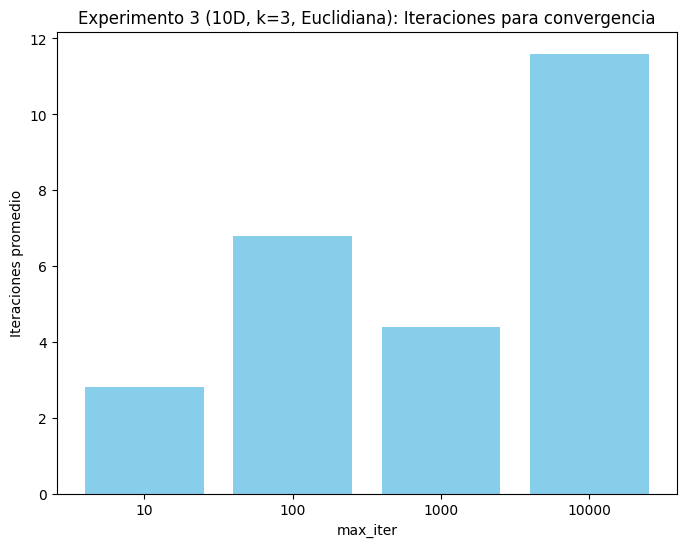

In [ ]:
exp3 = ejecutar_experimento(
    n_muestras=1000,
    dimensiones=10,
    k=3,
    distancia='euclidiana',
    max_iters=[10, 100, 1000, 10000],
    num_corridas=5
)

print("=== Resultados Experimento 3 (10D, k=3, Euclidiana) ===")
for m_iter, info in exp3.items():
    print(f"max_iter={m_iter}, iteraciones_promedio={info['iteraciones_promedio']:.2f}")

# Extraemos los valores para graficar
x_vals = list(exp3.keys())
y_vals = [info['iteraciones_promedio'] for info in exp3.values()]

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.bar([str(x) for x in x_vals], y_vals, color='skyblue')
plt.xlabel("max_iter")
plt.ylabel("Iteraciones promedio")
plt.title("Experimento 3 (10D, k=3, Euclidiana): Iteraciones para convergencia")
plt.show()

### **Experimento 4**: 100D, k=3, Euclidiana

=== Resultados Experimento 4 (100D, k=3, Euclidiana) ===
max_iter=10, iteraciones_promedio=3.00
max_iter=100, iteraciones_promedio=3.20
max_iter=1000, iteraciones_promedio=4.40
max_iter=10000, iteraciones_promedio=3.20


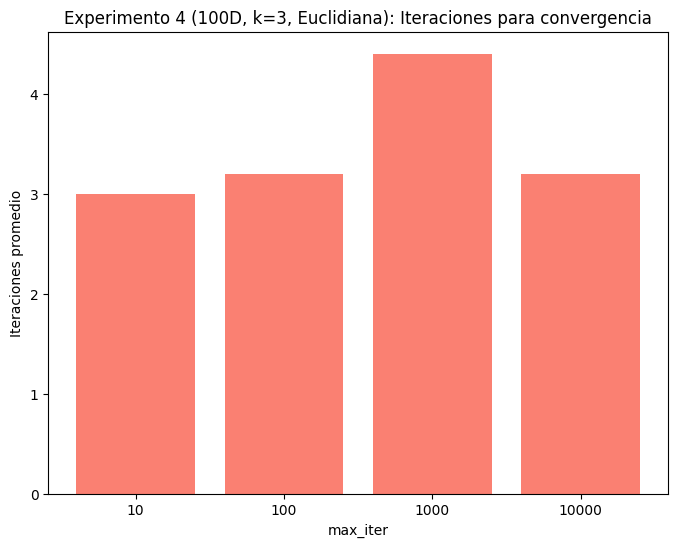

In [ ]:
exp4 = ejecutar_experimento(
    n_muestras=1000,
    dimensiones=100,
    k=3,
    distancia='euclidiana',
    max_iters=[10, 100, 1000, 10000],
    num_corridas=5
)

print("=== Resultados Experimento 4 (100D, k=3, Euclidiana) ===")
for m_iter, info in exp4.items():
    print(f"max_iter={m_iter}, iteraciones_promedio={info['iteraciones_promedio']:.2f}")


# Extraemos los valores para graficar
x_vals_4 = list(exp4.keys())
y_vals_4 = [info['iteraciones_promedio'] for info in exp4.values()]

plt.figure(figsize=(8,6))
plt.bar([str(x) for x in x_vals_4], y_vals_4, color='salmon')
plt.xlabel("max_iter")
plt.ylabel("Iteraciones promedio")
plt.title("Experimento 4 (100D, k=3, Euclidiana): Iteraciones para convergencia")
plt.show()

### **Experimento 5**: 3D, Variando k (2, 3, 5, 10), Euclidiana, max_iter = 1000

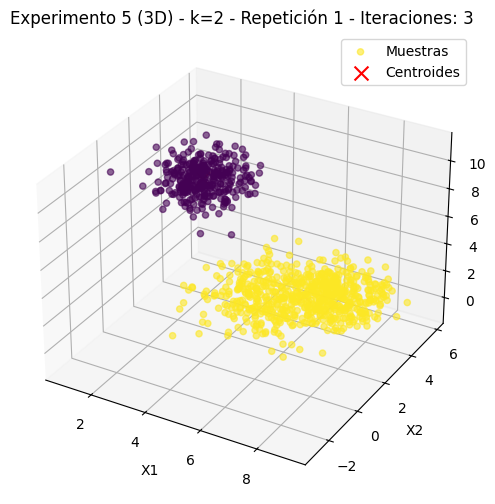

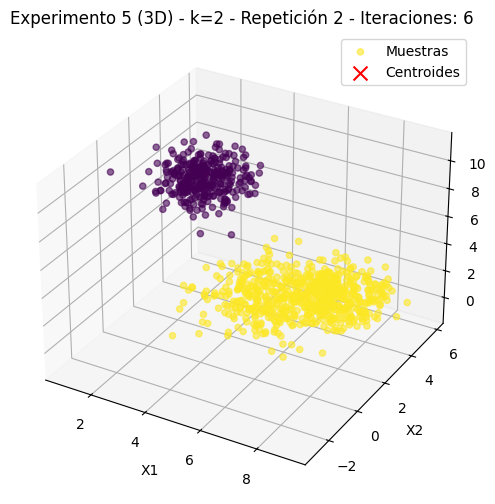

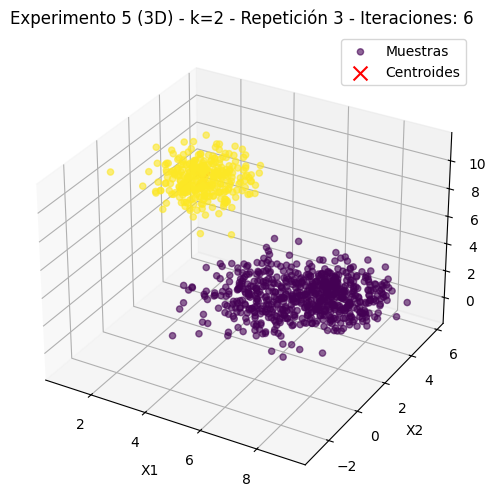

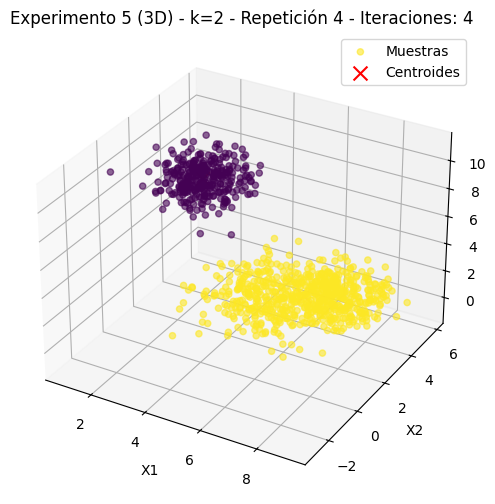

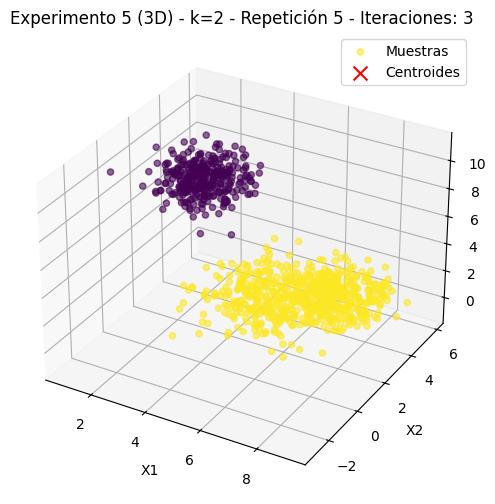

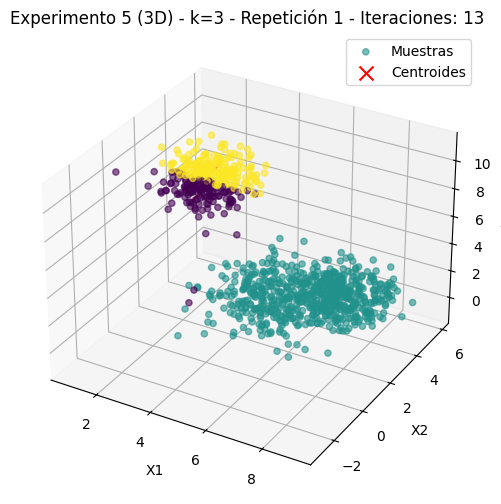

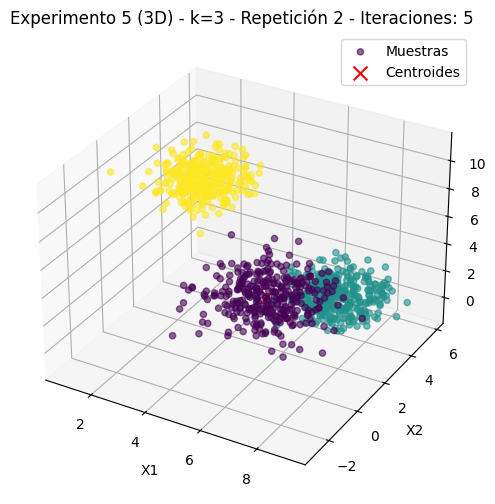

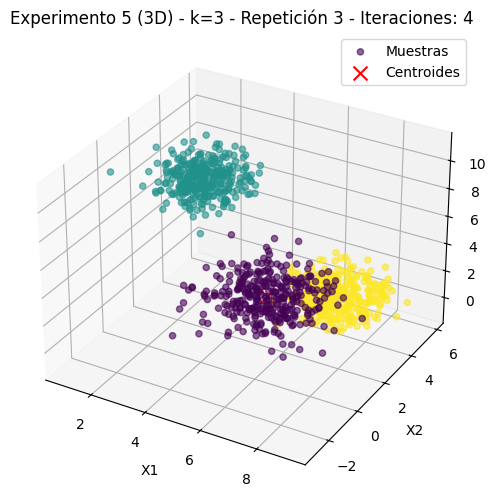

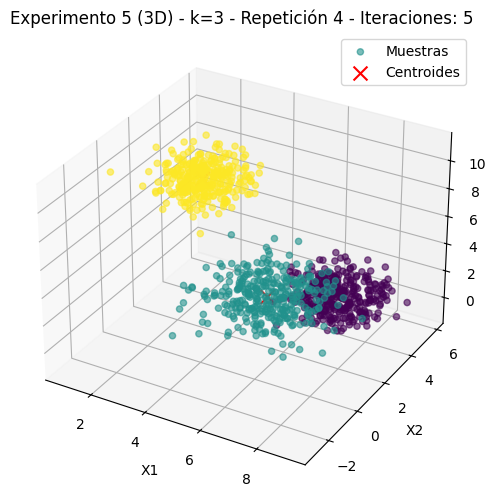

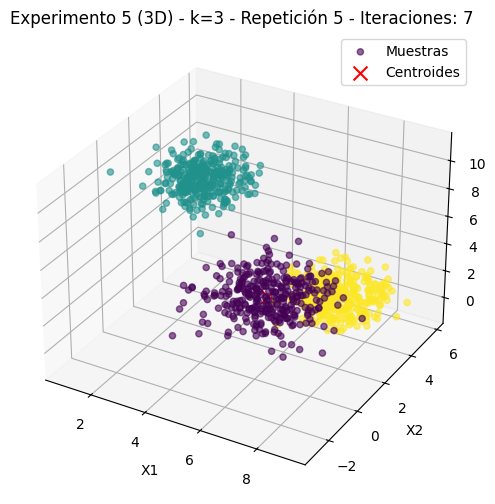

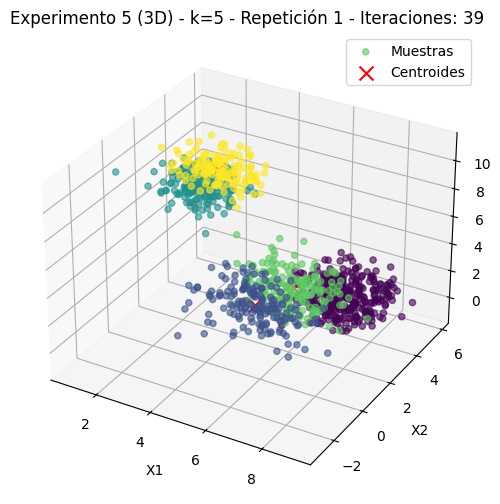

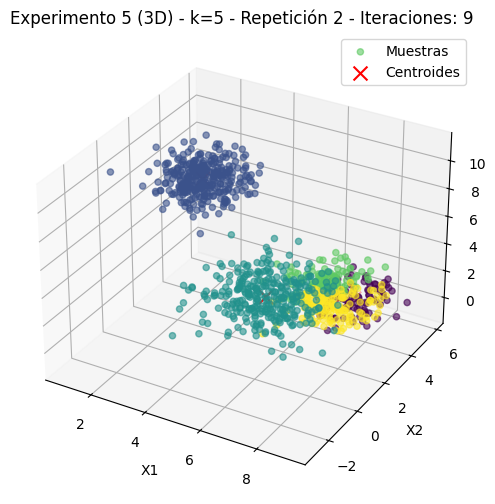

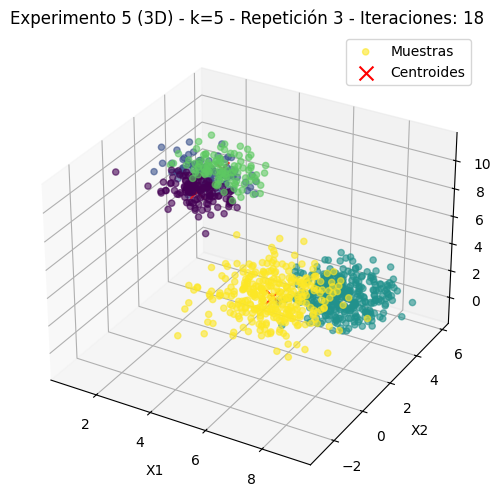

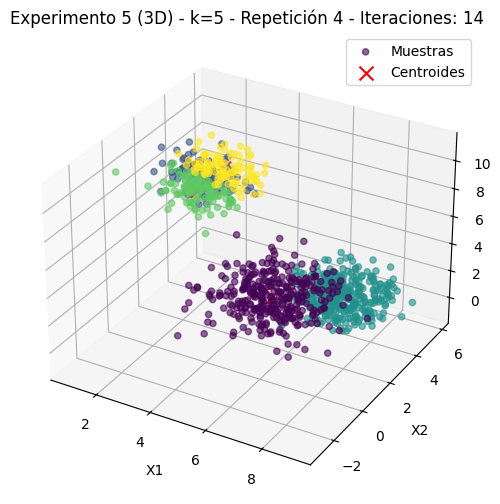

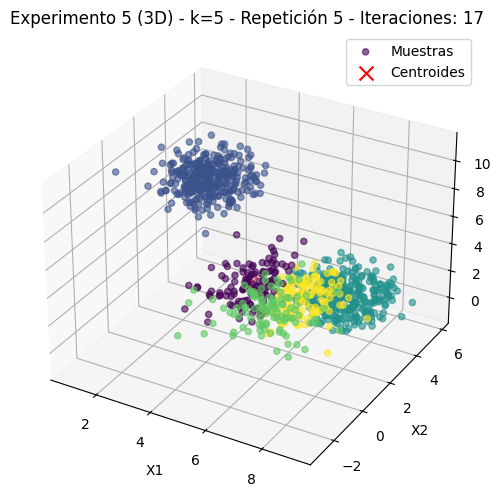

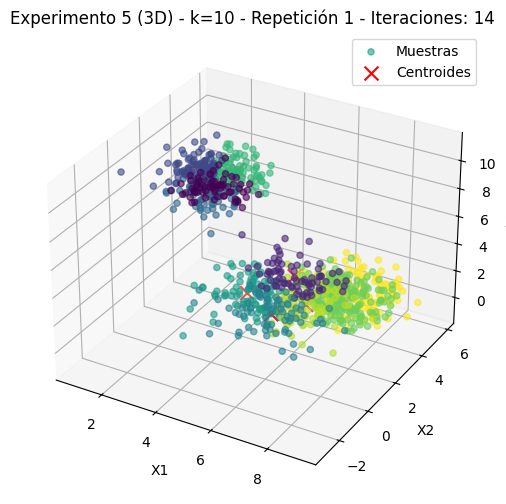

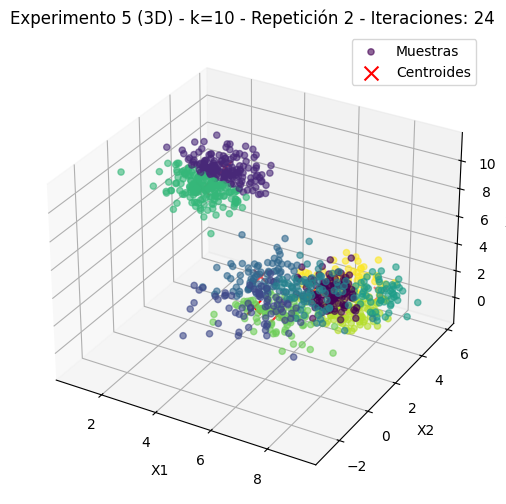

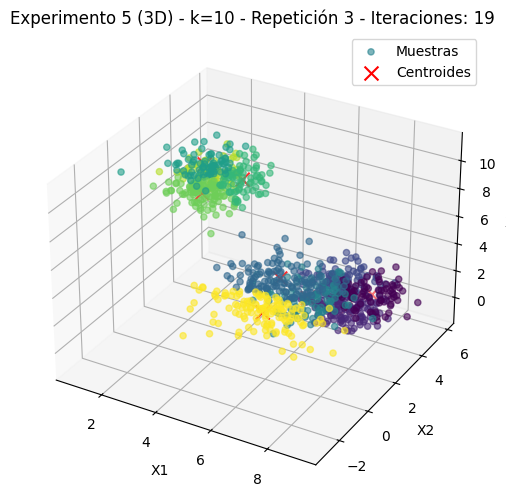

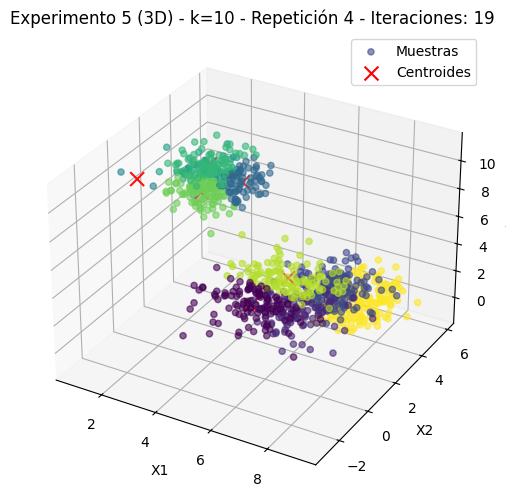

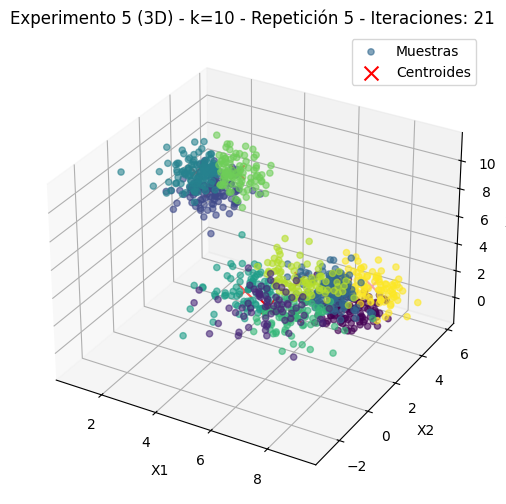

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Generamos los datos 3D una sola vez para mantener la consistencia entre repeticiones
X_3D = generar_datos_sinteticos(n_muestras=1000, dimensiones=3)

# Número de repeticiones (corridas)
num_corridas = 5

# klusters
k_values = [2, 3, 5, 10]

for k in k_values:
    for rep in range(num_corridas):
        # Ejecutamos K-Means para cada repetición
        centroides, etiquetas, it = kmeans(X_3D, k=k, max_iter=1000, distancia='euclidiana')

        # Creamos una nueva figura 3D para la repetición actual
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')

        # Graficamos las muestras en 3D
        scatter = ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2],
                             c=etiquetas, cmap='viridis', alpha=0.6, label='Muestras', zorder=1)

        # Graficamos los centroides
        ax.scatter(centroides[:, 0], centroides[:, 1], centroides[:, 2],
                   c='red', marker='x', s=100, label='Centroides', zorder=2)

        ax.set_title(f"Experimento 5 (3D) - k={k} - Repetición {rep+1} - Iteraciones: {it}")
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        ax.set_zlabel("X3")
        ax.legend()
        plt.show()

### **Experimento 6**: 1000 muestras, 2D, k = 5, distancia euclidiana, manhattan y mahalanobis, max iteraciones = 1000

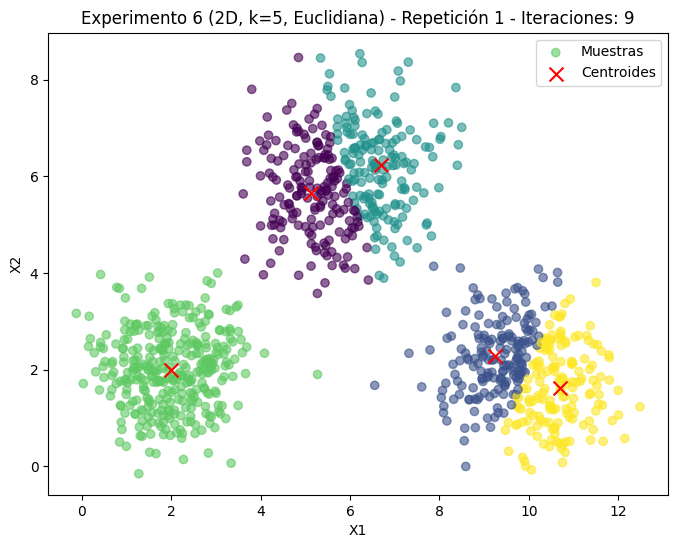

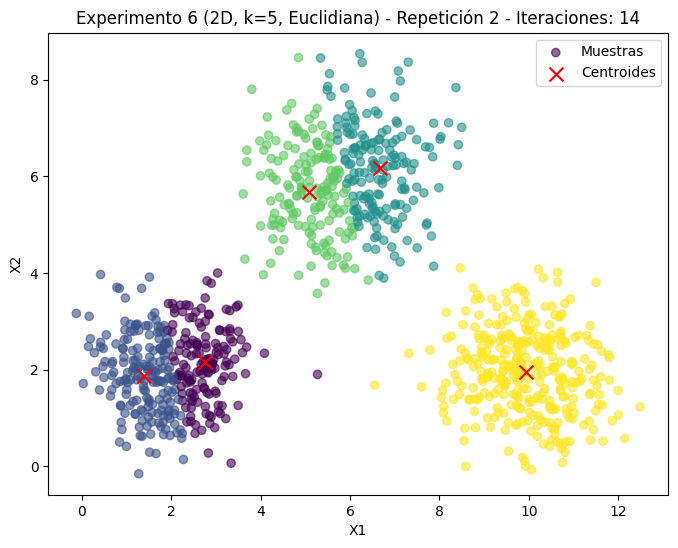

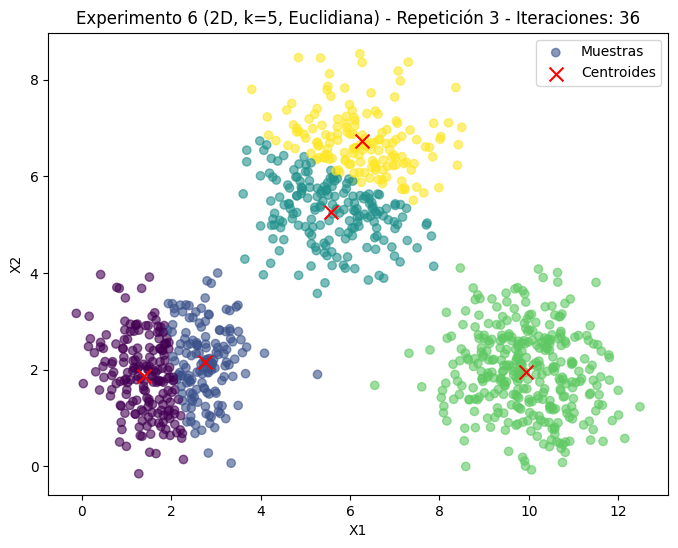

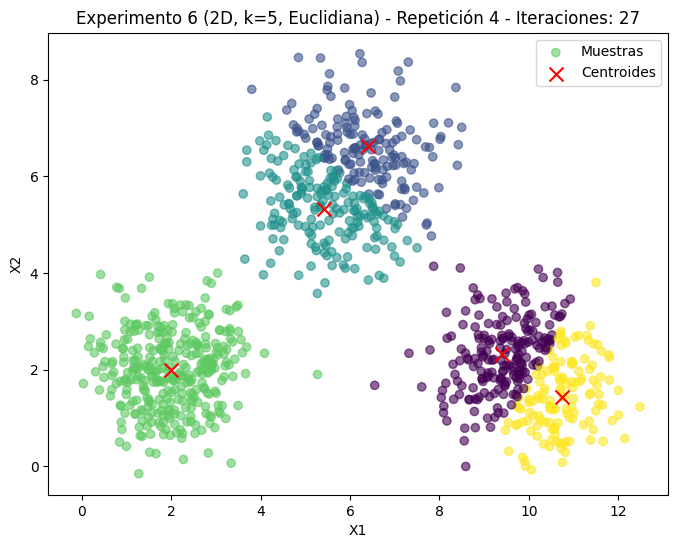

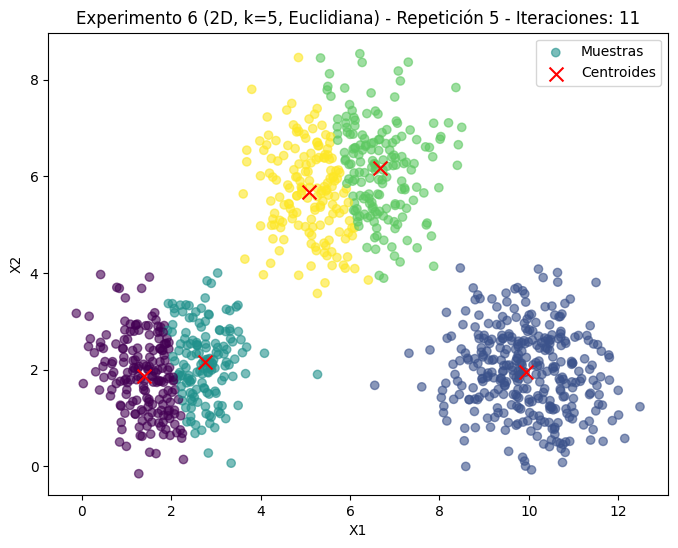

In [ ]:
X_2D = generar_datos_sinteticos(n_muestras=1000, dimensiones=2)

# Número de repeticiones (corridas)
num_corridas = 5

for rep in range(num_corridas):
    # Ejecutamos K-Means para cada repetición usando distancia Euclidiana
    centroides, etiquetas, it = kmeans(X_2D, k=5, max_iter=1000, distancia='euclidiana')

    # Creamos la gráfica para la repetición actual
    plt.figure(figsize=(8,6))
    plt.scatter(X_2D[:, 0], X_2D[:, 1], c=etiquetas, cmap='viridis', alpha=0.6, label='Muestras', zorder=1)
    plt.scatter(centroides[:, 0], centroides[:, 1], c='red', marker='x', s=100, label='Centroides', zorder=2)
    plt.title(f"Experimento 6 (2D, k=5, Euclidiana) - Repetición {rep+1} - Iteraciones: {it}")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

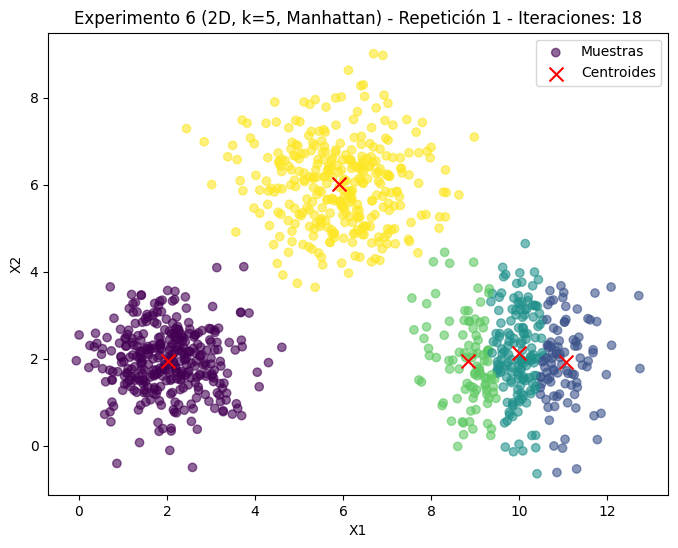

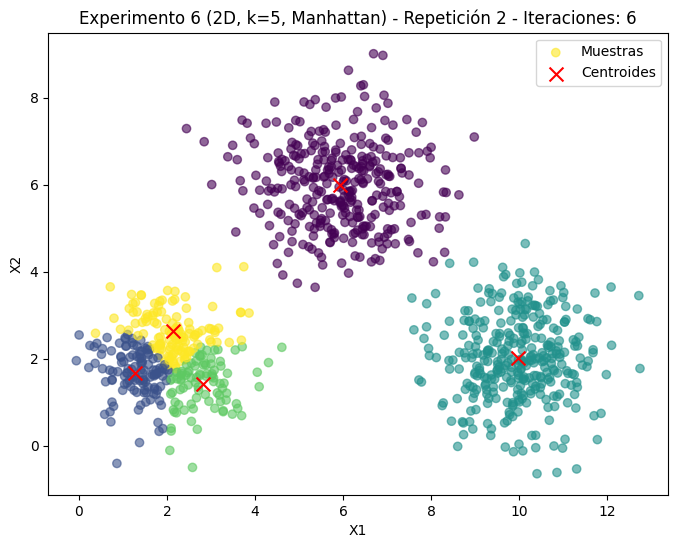

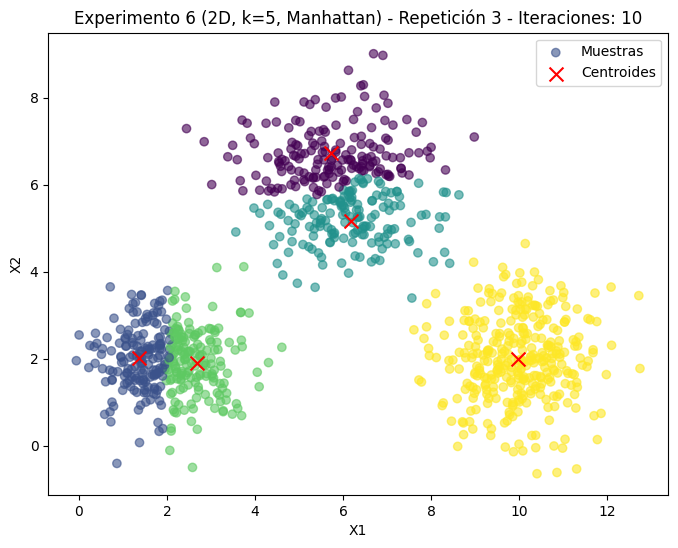

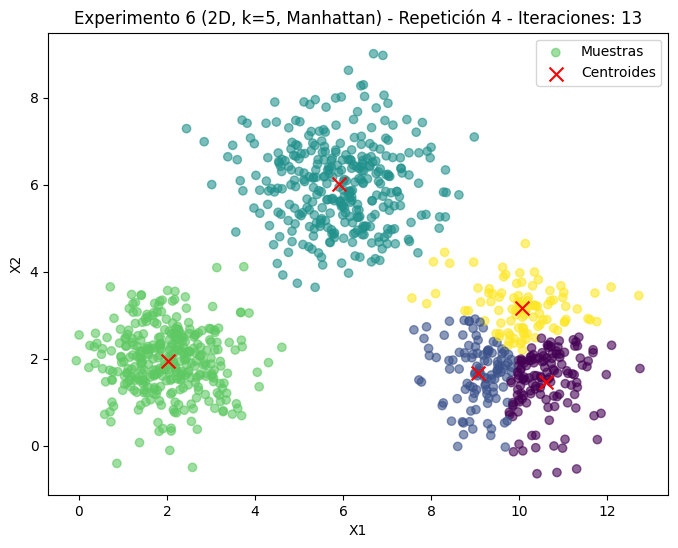

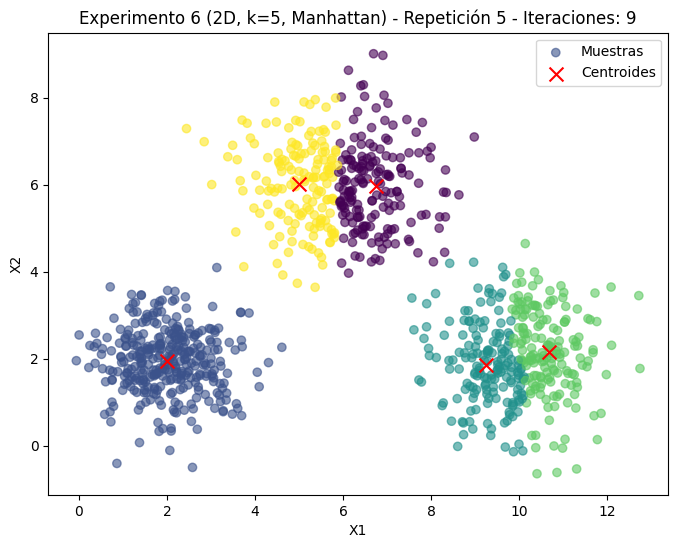

In [ ]:
X_2D = generar_datos_sinteticos(n_muestras=1000, dimensiones=2)

# Número de repeticiones (corridas)
num_corridas = 5

for rep in range(num_corridas):
    # Ejecutamos K-Means para cada repetición usando distancia Manhattan
    centroides, etiquetas, it = kmeans(X_2D, k=5, max_iter=1000, distancia='manhattan')

    # Creamos la gráfica para la repetición actual
    plt.figure(figsize=(8,6))
    plt.scatter(X_2D[:, 0], X_2D[:, 1], c=etiquetas, cmap='viridis', alpha=0.6, label='Muestras', zorder=1)
    plt.scatter(centroides[:, 0], centroides[:, 1], c='red', marker='x', s=100, label='Centroides', zorder=2)
    plt.title(f"Experimento 6 (2D, k=5, Manhattan) - Repetición {rep+1} - Iteraciones: {it}")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

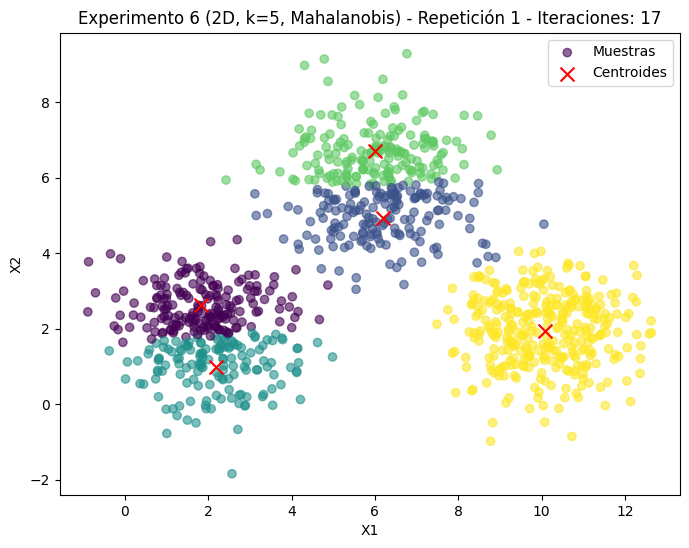

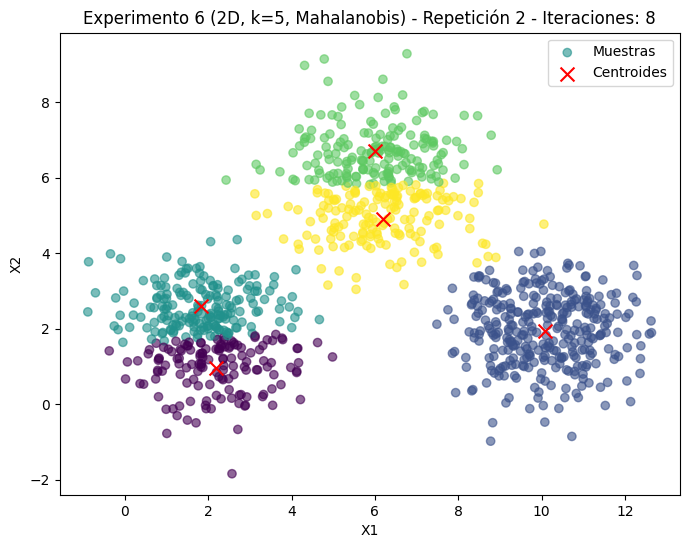

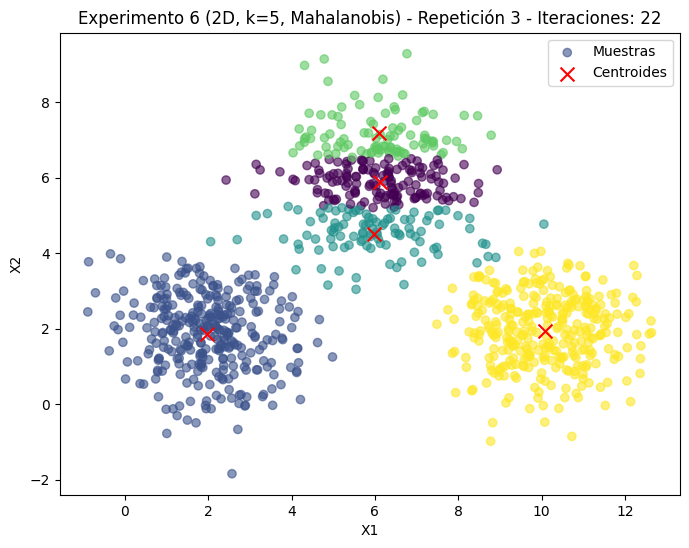

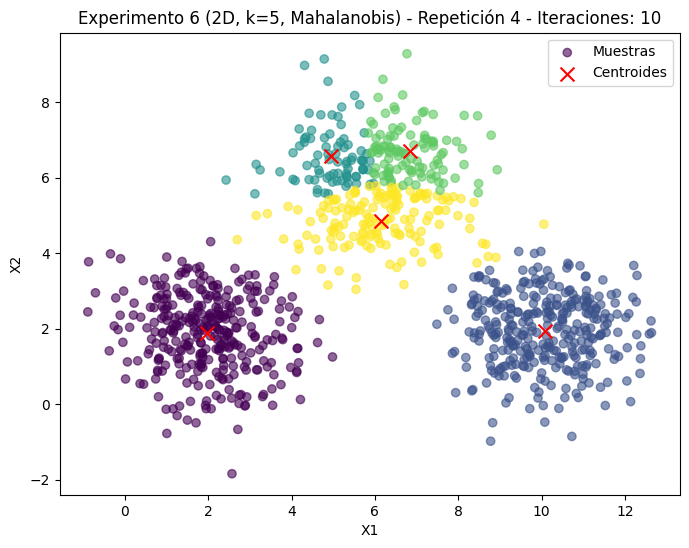

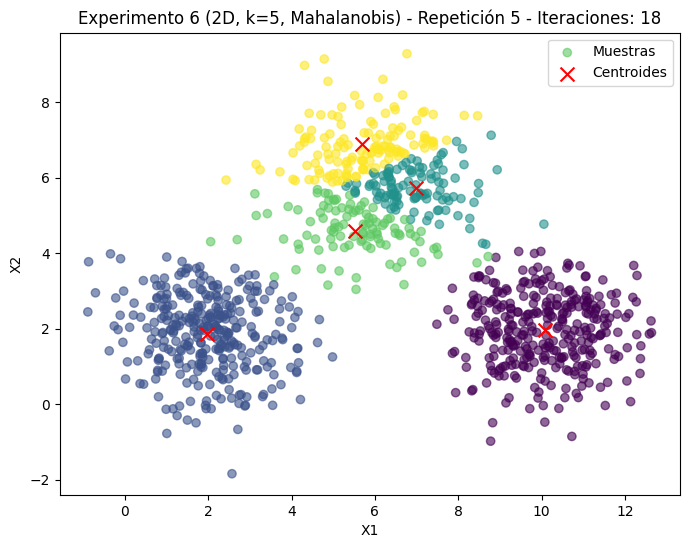

In [ ]:
X_2D = generar_datos_sinteticos(n_muestras=1000, dimensiones=2)

# Número de repeticiones (corridas)
num_corridas = 5

for rep in range(num_corridas):
    # Ejecutamos K-Means para cada repetición usando distancia Mahalanobis
    centroides, etiquetas, it = kmeans(X_2D, k=5, max_iter=1000, distancia='mahalanobis')

    # Creamos la gráfica para la repetición actual
    plt.figure(figsize=(8,6))
    plt.scatter(X_2D[:, 0], X_2D[:, 1], c=etiquetas, cmap='viridis', alpha=0.6, label='Muestras', zorder=1)
    plt.scatter(centroides[:, 0], centroides[:, 1], c='red', marker='x', s=100, label='Centroides', zorder=2)
    plt.title(f"Experimento 6 (2D, k=5, Mahalanobis) - Repetición {rep+1} - Iteraciones: {it}")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()